# Preprocessing of EEG data

In this notebook, we will go through the basics of preprocessing EEG data using MNE. We will be using the MNE sample data, so remember to run `pip install mne[data]` from the terminal.

To preprocces the data following steps are performed
1. Load the data
2. Exclude bad channels
3. Filtering
4. Artifact rejection

After preprocessing the data is epoched for further analysis.

In [86]:
import mne
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline


## 1. Load the sample data

Information about the sample data can be found [here](https://mne.tools/stable/overview/datasets_index.html). 

In [87]:
# reading the file & loading in the data
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file) # raw is an MNE object that contains the data of the class Raw
raw.info['bads'] = []

raw.load_data()

Opening raw data file /Users/laurapaulsen/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<Raw | sample_audvis_raw.fif, 376 x 166800 (277.7 s), ~481.8 MB, data loaded>

### Questions
Looking at the ouput from the load_data() function, answer the following questions:

1. How many EEG channels are there?
2. Do you see any EEG channels marked as bad during recording?
3. What is the sampling frequency?
4. How many minutes of data were recorded?

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


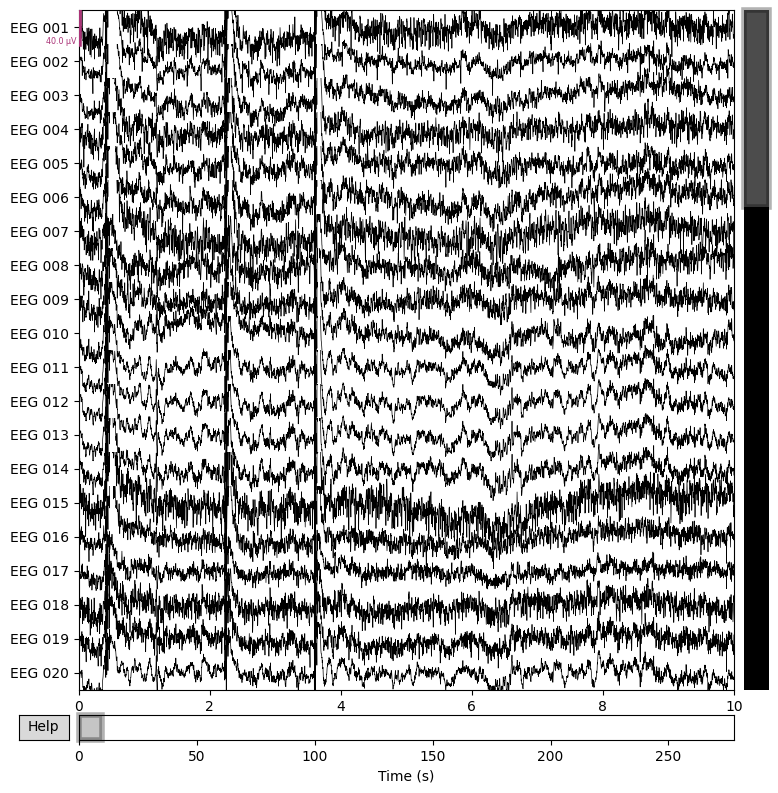

In [88]:
# selecting only EEG and stimulus data & plotting raw data
raw.pick_types(meg=False, eeg=True, stim=True, exclude=[])
raw.plot(); # the ; at the end of the line suppresses the output (if not used, the plot will be displayed twice)

Right now we are plotting using the default argument values of the plot() function. Try to play around with the function in order to:

**1. Plot all EEG channels simultaneously**

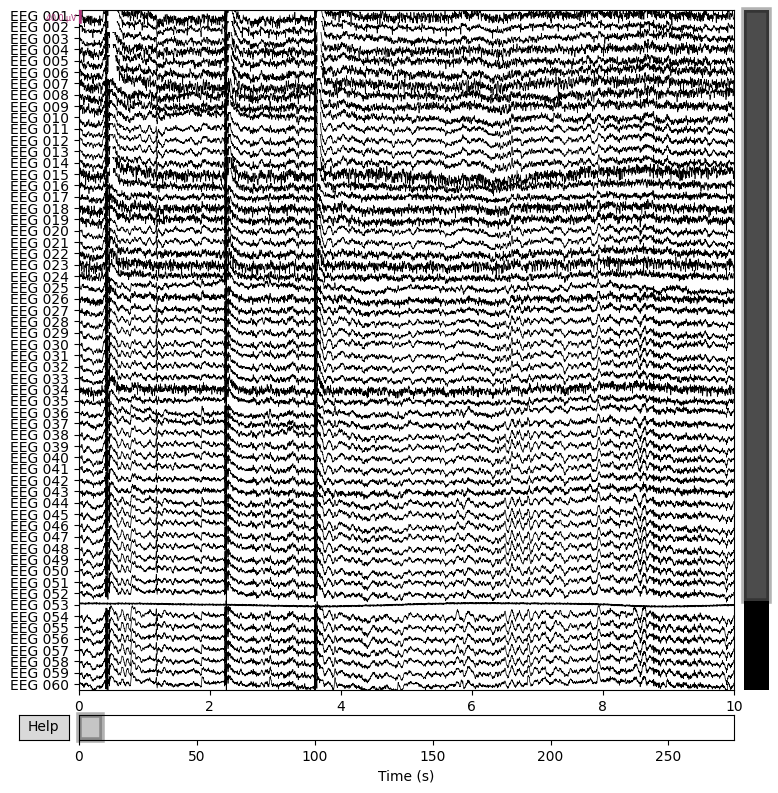

In [89]:
raw.plot(n_channels=60);

**2. Plot a full minute of the recording**

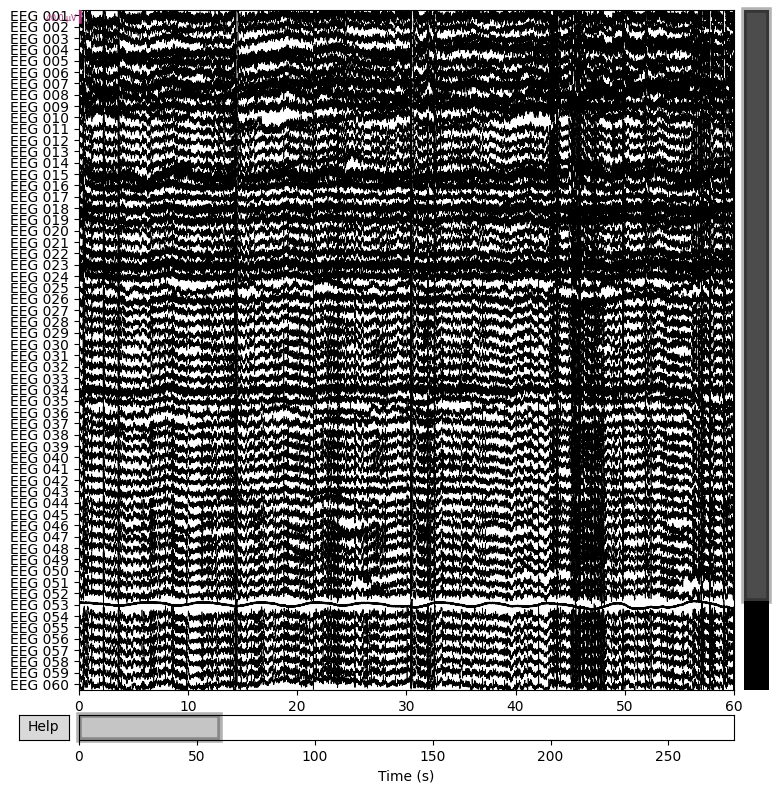

In [90]:
raw.plot(n_channels=60, duration=60);

## 2. Exclude bad channels
When plotting all channels simultaneously, it is evident that one of the channels is not really picking up any signal (that is, it is flat). This is a bad channel and should be excluded from further analysis. There are other ways that channels might be bad, such as being too noisy, or picking up signals from other parts of the body. In this case, we will just exclude the channel that is flat.

**Begin by marking the channel as bad using the info attribute of the raw object. Then, plot the data again to see that the channel is now excluded.**

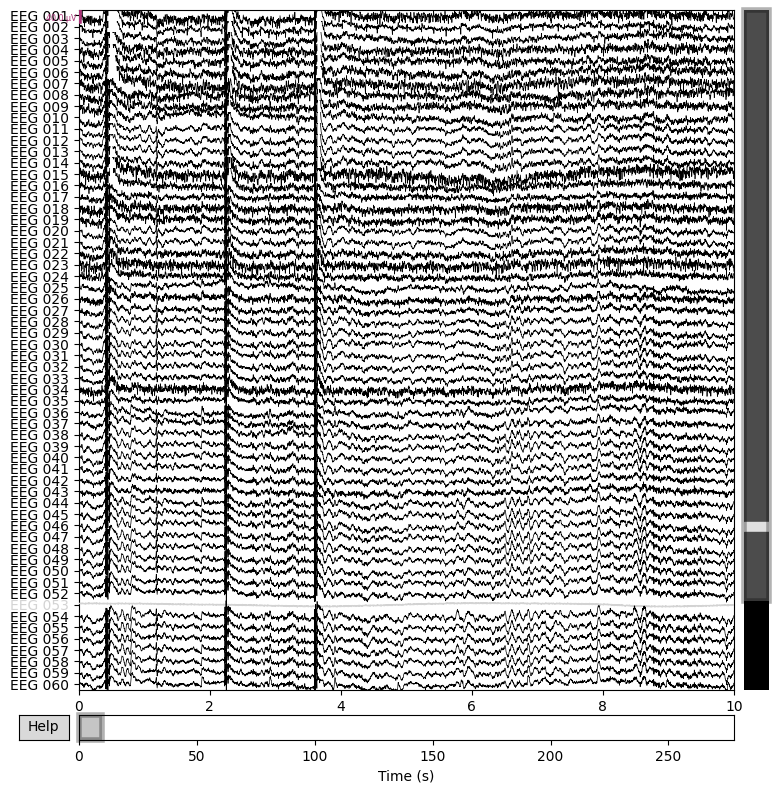

In [91]:
# input the name of the bad EEG channel here, e.g. ['EEG 002']
raw.info['bads'] = ['EEG 053']
raw.plot(n_channels=60);

**After marking the channel as bad, excluded it by using the pick_types() function.**

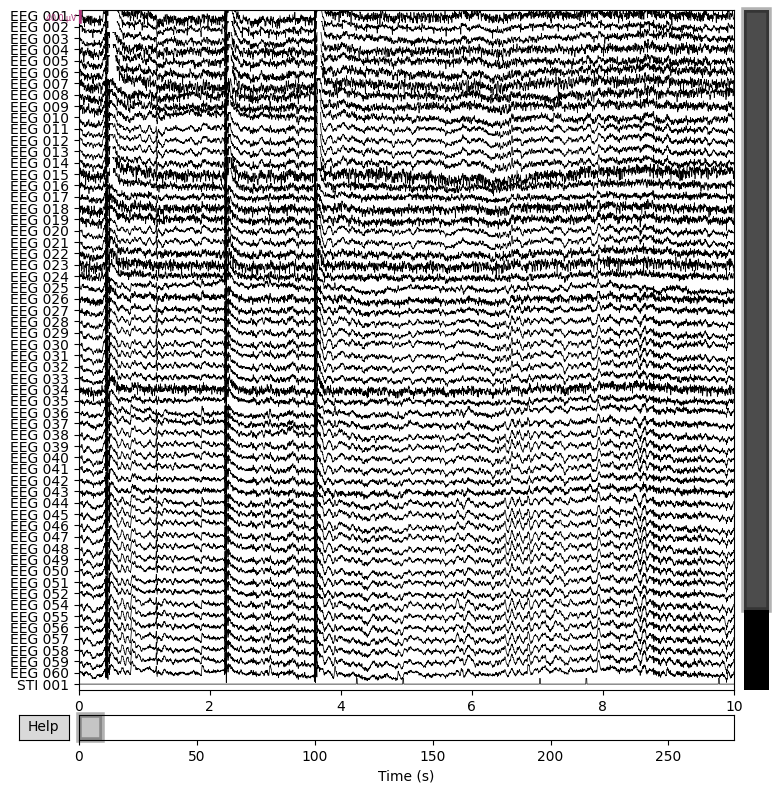

In [92]:
raw.pick_types(meg=False, eeg=True, stim=True, exclude='bads')
raw.plot(n_channels=60);

## 3. Filtering
Now let's filter the data. **Apply a high-pass filter at 0.1 Hz and a low-pass filter at 40 Hz, following the typical practises of EEG preprocessing.** The high-pass filter minimises slow drifts in the data (e.g. scalp potentials), while the low-pass filter excludes high-frequency noise (e.g. line noise (50 Hz) or EMG (muscle-related artefacts)), with frequencies higher than the frequencies of the signal we are interested in.

In [93]:
# high-pass filter the data
raw = raw.filter(0.1, None)

# low-pass filter the data
raw = raw.filter(None, 40)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 19821 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 199 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.1s finished


**Plot the data to inspect the effect of the filtering.**

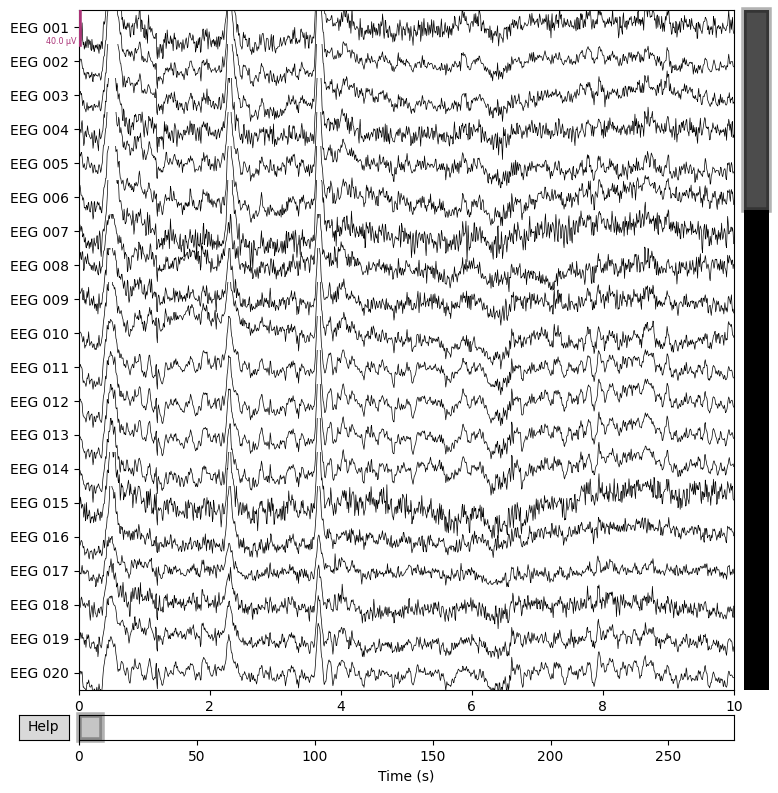

In [94]:
raw.plot();

### Question
1. Compare to the unfiltered data. What is the effect of the filtering on the data?

## 4. Artefact rejection
There are many ways to detect and deal with artefacts. Today, we simply select a value and reject anything above or below that value. We do this because we determine that values over or under this threshold are liekly not related to brain activity. For now, we just create the variable and then we use it to remove artefacts while epoching further along.

There are better ways to reject artefacts, such as using the ICA algorithm. An optional exercise using ICA will be provided at the end of the notebook.

In [95]:
# rejecting everything over or under a threshold of 150 microvolts
# anything above or belove this threshold is likely not brain activity but artefacts
# this is not doing anything yet, we just specify the threshold for later!

# extra note: using a dictionary as it allows to specify different thresholds for different channels (however we only have one channel type here)
reject = {'eeg': 150e-6}

# Epocing of EEG data
Now that the data has been preprocessed, we can epoch the data. Epoching is the process of cutting the continuous data into smaller segments, called epochs. Each epoch is a time window of the data, centered around an event of interest.

In MNE toolkit, the `Epochs` class is used to represent data that has been segmented into epochs, and it provides methods for averaging, baseline correction, plotting, and so forth.

**To begin with we need to locate the events. This can be done using the find_events() function.**

In [96]:
events = mne.find_events(raw)

320 events found
Event IDs: [ 1  2  3  4  5 32]


**Create a dictionary of what each event ID represents.**
By using '/' we can actually later index one dimension *across* the other, i.e. if we just write 'left' we get all events presented to the left side, both auditory and visual

In [97]:
event_id = {'auditory/left': 1,
              'auditory/right': 2,
              'visual/left': 3,
              'visual/right': 4,
              'smiley': 5,
              'button': 32
              }

**Visualise the events by using the mne.viz.plot_events() function**

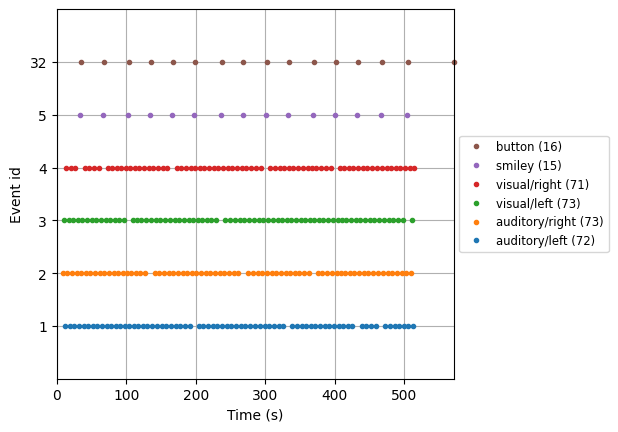

In [98]:
mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);

**Establish a time window for the epochs.**
One suggestion is to use a time window of 200 ms before the stimulus onset to 500 ms after the stimulus onset. 
The 200 milliseconds before the onset of the stimulus enables us to examine a baseline of activity without stimulus presentation. The 500 milliseconds after the stimulus onset denote the time in which we expect the effect to occur. 

When establishing a time window, it is important to consider the pace of the experiment. We do not want to include data from other trials. 

In [99]:
tmin, tmax = -0.2, 0.5

**Create a picks variable with only EEG channels**

In [100]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False)

**Create the epochs by using the mne.Epochs class**

In [101]:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
320 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 320 events and 421 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 006', 'EEG 007', 'EEG 015']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 006', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EE

## Downsample the data
To reduce the amount of data we have to work with, and the amount of time it takes to run the analysis the data is downsampled. This is done after epoching, since before epoching can potentially mess with the precision of the extraction of epochs.

**Downsample the data to 250 Hz**

In [102]:
epochs_resampled = epochs.resample(250)

# ERP analysis
Now that the data is epoched, we can start to analyse the data. 

**To start of group the epochs by modality (i.e. visual and auditory)**

In [103]:
# now the '/' used in the event IDs comes in handy! To get all epochs with auditory stimuli, we can index 'auditory' across the left/right dimension (and 'visual', of course)
# that way we don't have to specify 'auditory_left' and 'auditory_right' etc.
aud_epochs = epochs_resampled['auditory']
vis_epochs = epochs_resampled['visual']

**Now use the plot_image() method of the Epochs class to plot the channel 'EEG 021' for both auditory and visual epochs**

These plots show each epoch as one row of the image map for the chosen channel, with color representing signal magnitude. The average evoked response and the sensor location are shown below the image. This gives us an idea of whether there is consistency in the signal.

Not setting metadata
131 matching events found
No baseline correction applied
0 projection items activated


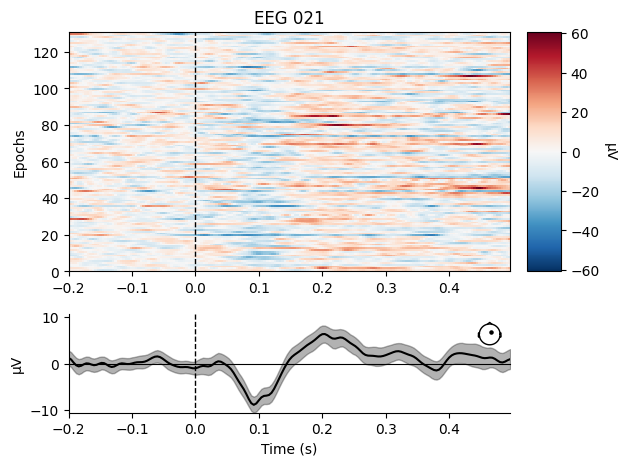

Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


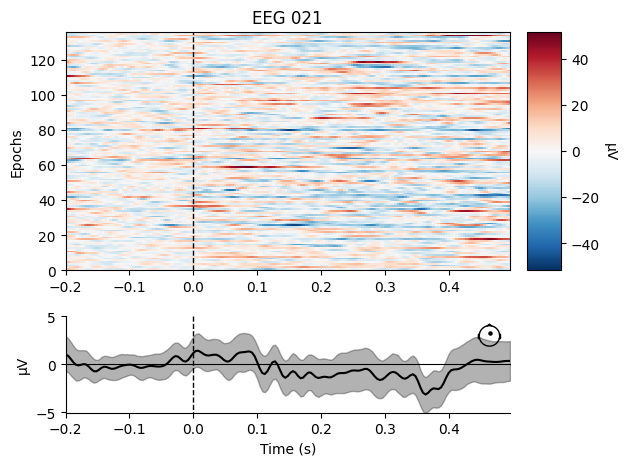

In [104]:
# plotting one channel as an example for each modality
aud_epochs.plot_image(picks=['EEG 021']);
vis_epochs.plot_image(picks=['EEG 021']);

### Questions
1. In your view, which is the most consistent signal of the two? Why do you think that is? (hints: where is the EEG 021 channel located on the scalp? Try using plot_sensors and flagging show_names=True)

2. Which channel would you choose if you were to reverse the pattern of the signal consistencies? Why? Try it out!

## Evoked responses
Unlike `Epochs`, which contain multiple trials that are each associated with a condition label (that is the event ID), `Evoked` objects are averages across trials for a single condition. Thus we have to create a separate `Evoked` object for each condition in our experiment.

**Create an Evoked object for each modality**

Hint: use the average() method of the Epochs class

In [105]:
# creating evokeds for auditory condition by averaging over epochs
aud_evoked = aud_epochs.average()

# creating evokeds for visual condition
vis_evoked = vis_epochs.average()

**Compare the two evokeds using mne.viz.plot_compare_evokeds()**

combining channels using "gfp"
combining channels using "gfp"


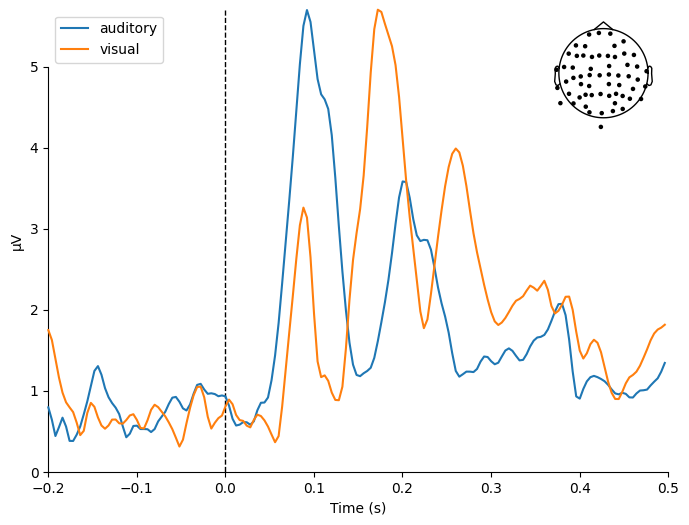

[<Figure size 800x600 with 2 Axes>]

In [106]:
# plotting the two evokeds together
mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked),
                             legend='upper left', show_sensors='upper right')

Looking a bit closer at the averaged responses, here visualized with the global field power (GFP). GFP is actually the same as taking the standard deviation across all channels in each time sample. This tells us in which timepoints we see the biggest difference between different channels, which in turn is indicative of some kind of (more or less) focal activity. 

### Questions
1. Looking at the plot, where in time do you see the strongest response in the auditory and visual conditions, respectively?
2. Do those timepoints match any well-known components relevant in this context? (hint: N100 and N170)

**Now lets use the plot_joint() method of the Evoked class to plot the evoked responses for both modalities.**

This function generates a combination of “butterfly” plots (waveforms of all electrodes overlaid) and topographic maps

No projector specified for this dataset. Please consider the method self.add_proj.


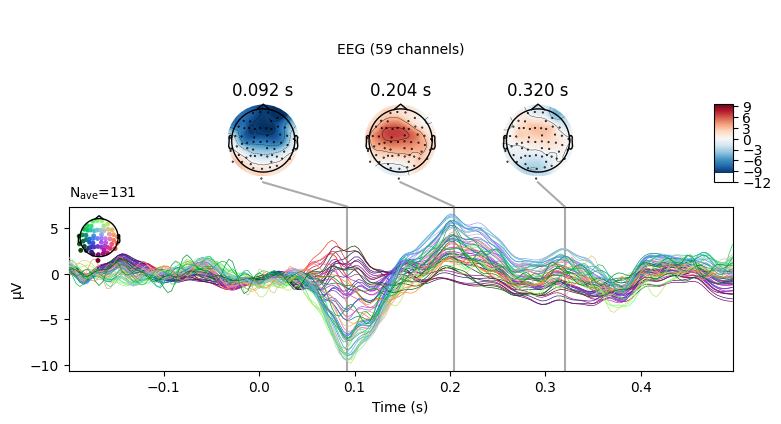

No projector specified for this dataset. Please consider the method self.add_proj.


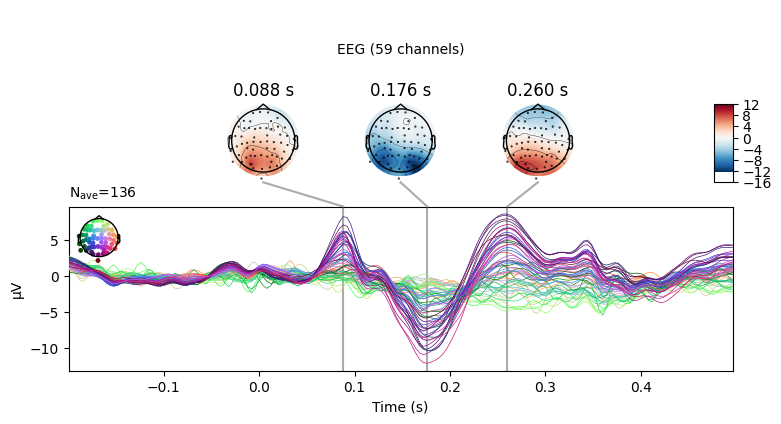

In [107]:
aud_evoked.plot_joint(picks='eeg');
vis_evoked.plot_joint(picks='eeg');

### Question
1. Do those plots match your observations from the GFP-plots?

NOTES:

Redefine to common average?

Set montage

Also comment on inplace methods

# Optional exercise: ICA
ICA can be used for artefact detection, since it identifies seperate components of the signal that have been combined during recording. That means that we can actually separate noise compoenents, such as eye blinks, from the rest of the signal, and thereby exclude them.

In [108]:
import sklearn

In [109]:
# set up and fit the ica with 800 iterations with a random seed at 97
# n_components=0.95 ensures that the number of components selected explain at least 95% of the variance in the data
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(raw)

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by explained variance: 7 components
Fitting ICA took 1.4s.


<ICA | raw data decomposition, method: fastica (fit in 27 iterations on 166800 samples), 7 ICA components (59 PCA components available), channel types: eeg, no sources marked for exclusion>

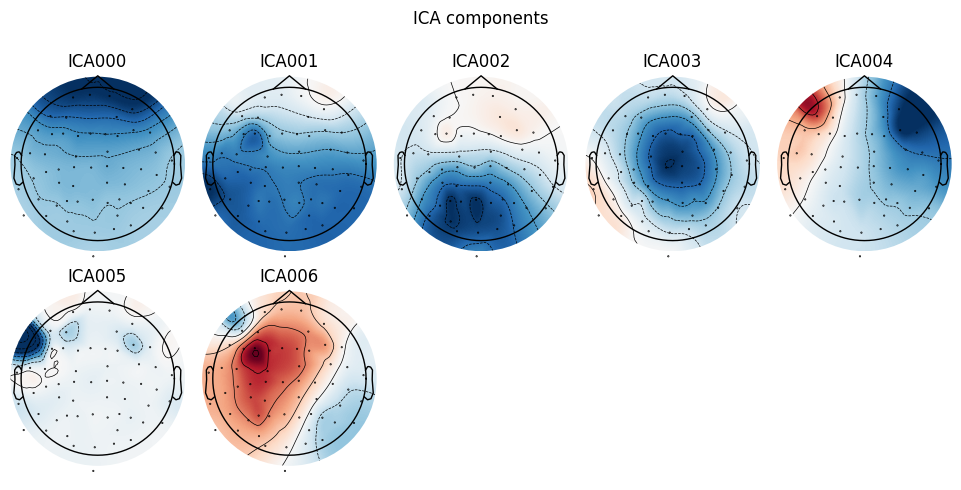

In [110]:
# plotting the ica components
ica.plot_components();

Creating RawArray with float64 data, n_channels=7, n_times=166800
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


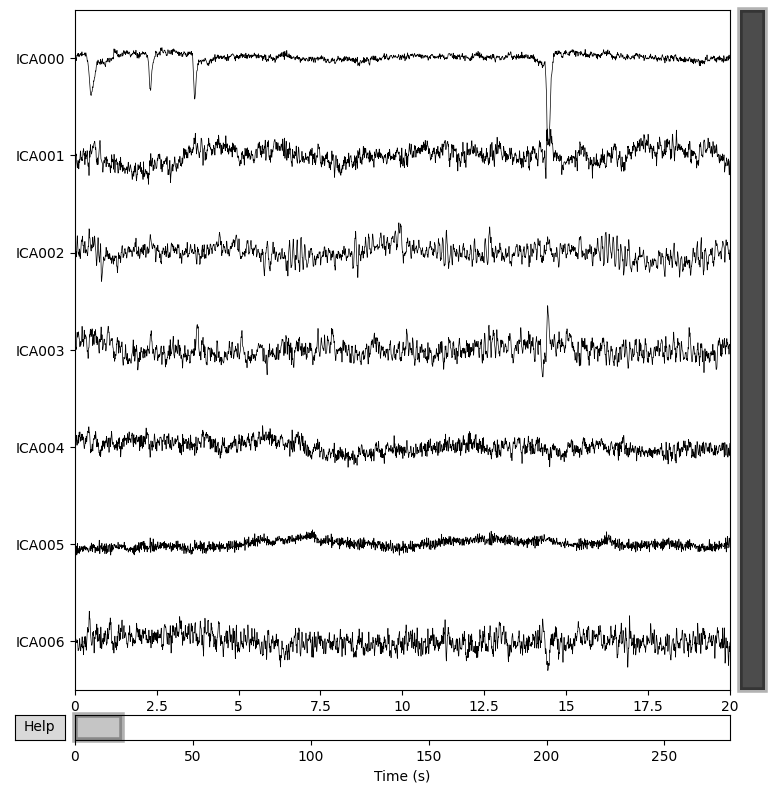

In [111]:
# plotting the time courses of the ica components
ica.plot_sources(raw);

### Questions
1. There are two components that are related to eye blinks. What are they? (hint: look at the topographies of the components and the time courses of the components)

**Exclude these components**

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


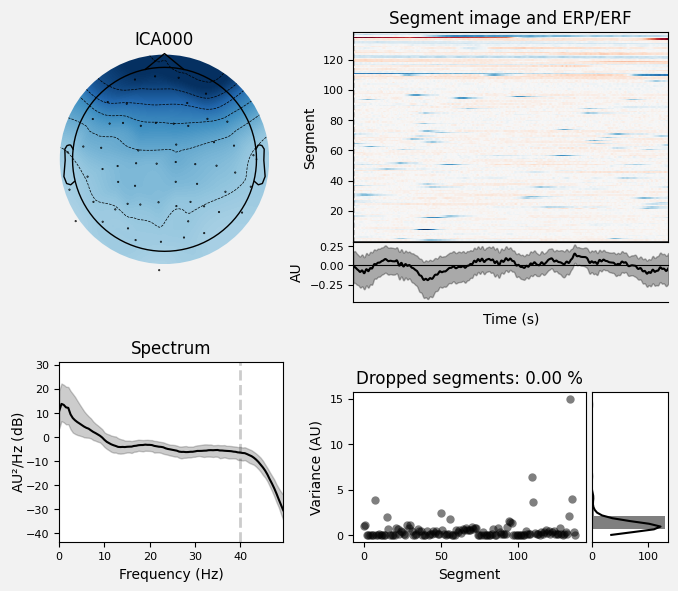

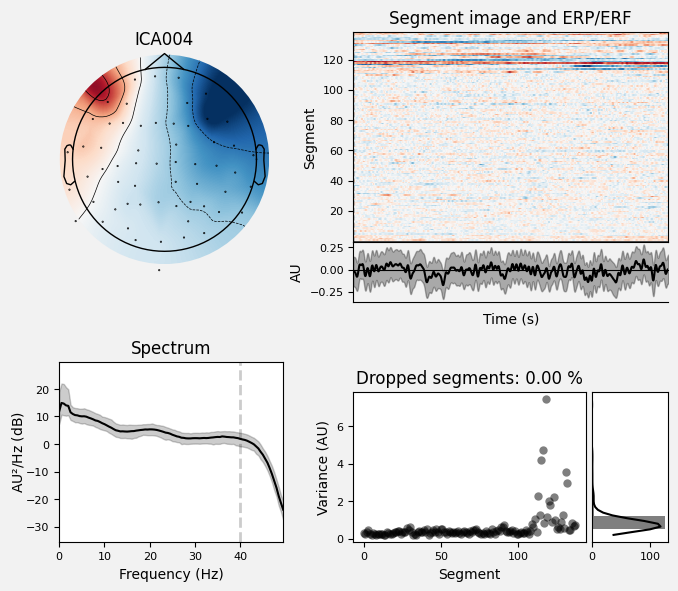

In [112]:
# the first component is excluded based on visual inspection
ica.exclude = [0, 4]
ica.plot_properties(raw, picks=ica.exclude);

In [113]:
# applying the ica to the data
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 2 ICA components
    Projecting back using 59 PCA components


<Raw | sample_audvis_raw.fif, 68 x 166800 (277.7 s), ~89.5 MB, data loaded>

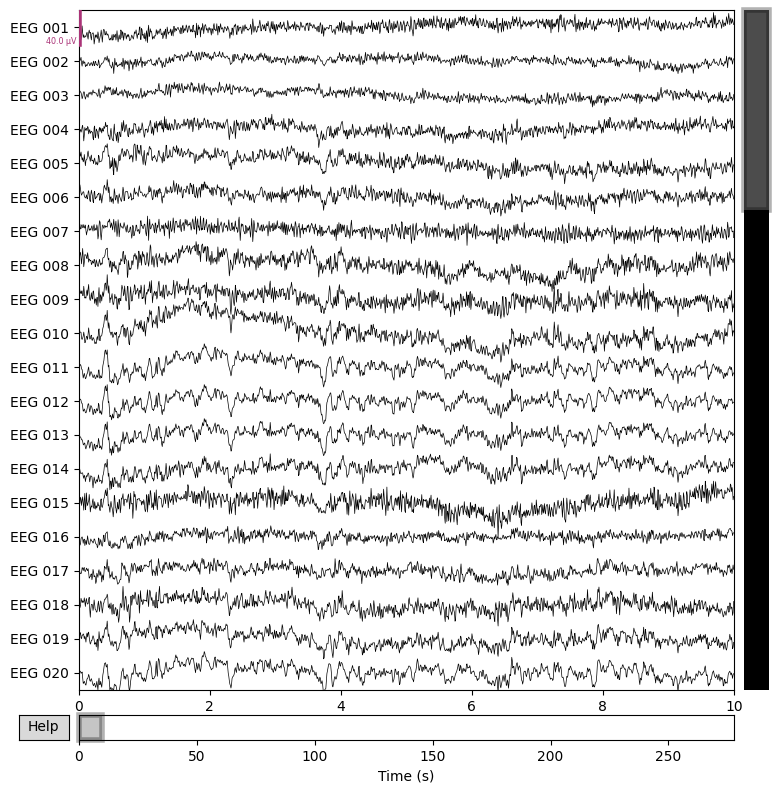

In [114]:
# plotting the data after filtering and ica
raw.plot();

Now try to run 
- artefact-detection
- epoching
- downsampling
- the single-trial plots
- the evokeds plots

(i.e. exactly like you just did in the above)

Now compare your results with and without ICA - can you tell any differences between the two, just qualitatively speaking?